In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from warnings import filterwarnings
from shapely.geometry import Point
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk import ngrams
filterwarnings("ignore")
airbnb_raw_plus_review = pd.read_csv('https://media.githubusercontent.com/media/imadahmad97/EDA-of-Airbnb-Data/main/DataSets/Clean%20Data/airbnb_raw_plus_review.csv')

## Paris GEOJSON Map

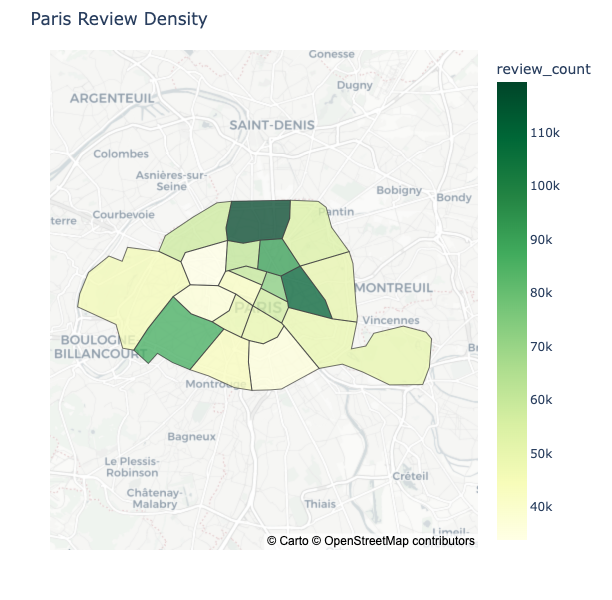

In [2]:
#read the GeoJson file
census_file = 'https://raw.githubusercontent.com/imadahmad97/EDA-of-Airbnb-Data/main/DataSets/GEOJSON%20Files/communes-75-paris.geojson'
cendf = gpd.read_file(census_file)

# Let's index by district name
cendf.set_index('nom', inplace=True)
cendf_2 = cendf

# Filter cleaned file to only Paris
paris_df_map = airbnb_raw_plus_review[(airbnb_raw_plus_review['city']=='Paris')].reset_index()

#combine the long and lat as coordinates
paris_df_map['coordinates'] = list(zip(paris_df_map["longitude"], paris_df_map["latitude"]))
paris_df_map['coordinates'] = paris_df_map['coordinates'].apply(Point)
locsdf = gpd.GeoDataFrame(paris_df_map, geometry='coordinates')
locsdf = locsdf.set_crs(epsg=4326) 

output_dict=dict() 
coordinates = paris_df_map['coordinates'].tolist()
count_of_review = paris_df_map['review_id_distinct_count'].tolist()
geo = cendf_2['geometry'].tolist()
district_code = cendf_2['code'].tolist()
output_dict=dict() 
for j in range(len(geo)):
    for i in range(len(coordinates)):
        if geo[j].contains(coordinates[i]):
            if district_code[j] in output_dict:
                if not (np.isnan(count_of_review[i])):
                    output_dict[district_code[j]]+=count_of_review[i]
            else:
                if not (np.isnan(count_of_review[i])):
                    output_dict[district_code[j]]=count_of_review[i]

output_dict_paris = output_dict

#turn the dictionary to dataframe, then left join to the cendf file
output_dict_df = pd.DataFrame(output_dict_paris.items(), columns=['code', 'review_count'])
cendf_2['nom'] = cendf_2.index
cendf_3 = pd.merge(cendf_2, output_dict_df , on='code', how='left')
cendf_3.set_index('nom', inplace=True)

# Choropleth map of calgary resident count via px.choropleth_mapbox()
cendf_4 = cendf_3.to_crs(epsg=4326)

# plot the map
fig = px.choropleth_mapbox(cendf_4, geojson=cendf_4,
                           locations=cendf_4.index, 
                           color="review_count",
                           color_continuous_scale = 'YlGn',
                           center={"lat": 48.8566, "lon": 2.3522}, # Paris
                           mapbox_style="carto-positron",
                           opacity=0.75,
                           zoom=10, 
                           title = 'Paris Review Density')

fig.update_layout(margin={"r":50,"t":50,"l":50,"b":50}, 
                  autosize=True,
                  height=600 )

fig.show()

## Rome GEOJSON Map

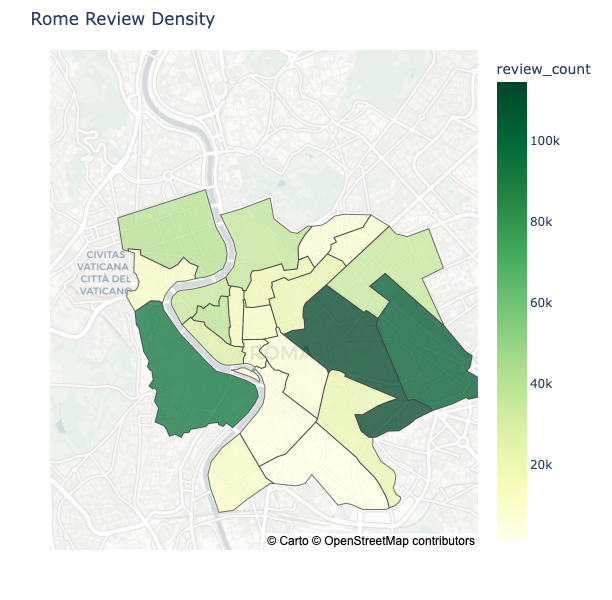

In [3]:
#read the GeoJson file
census_file = 'https://raw.githubusercontent.com/imadahmad97/EDA-of-Airbnb-Data/main/DataSets/GEOJSON%20Files/rome-rioni_.geojson'
cendf = gpd.read_file(census_file)

# Let's index by district name
cendf.set_index('name', inplace=True)
cendf_2 = cendf

# Filter cleaned file to only Rome
rome_df_map = airbnb_raw_plus_review[(airbnb_raw_plus_review['city']=='Rome')].reset_index()

#combine the long and lat as coordinates
rome_df_map['coordinates'] = list(zip(rome_df_map["longitude"], rome_df_map["latitude"]))
rome_df_map['coordinates'] = rome_df_map['coordinates'].apply(Point)
locsdf = gpd.GeoDataFrame(rome_df_map, geometry='coordinates')
locsdf = locsdf.set_crs(epsg=4326)

#for counting the number of reviews in each district

coordinates = rome_df_map['coordinates'].tolist()
count_of_review = rome_df_map['review_id_distinct_count'].tolist()
geo = cendf_2['geometry'].tolist()
district_code = cendf_2['cartodb_id'].tolist()
output_dict=dict() 
for j in range(len(geo)):
    for i in range(len(coordinates)):
        if geo[j].contains(coordinates[i]):
            if district_code[j] in output_dict:
                if not (np.isnan(count_of_review[i])):
                    output_dict[district_code[j]]+=count_of_review[i]
            else:
                if not (np.isnan(count_of_review[i])):
                    output_dict[district_code[j]]=count_of_review[i]

#print(output_dict)
output_dict_rome = output_dict

#turn the dictionary to dataframe, then left join to the cendf file
output_dict_df = pd.DataFrame(output_dict_rome.items(), columns=['cartodb_id', 'review_count'])
cendf_2['name'] = cendf_2.index
cendf_3 = pd.merge(cendf_2, output_dict_df , on='cartodb_id', how='left')
cendf_3.set_index('name', inplace=True)

# Choropleth map of calgary resident count via px.choropleth_mapbox()
cendf_4 = cendf_3.to_crs(epsg=4326)

# plot the map
fig = px.choropleth_mapbox(cendf_4, geojson=cendf_4,
                           locations=cendf_4.index, 
                           color="review_count",
                           color_continuous_scale = 'YlGn',
                           center={"lat": 41.90, "lon": 12.48}, # Rome
                           mapbox_style="carto-positron",
                           opacity=0.75,
                           zoom=12, 
                           title = 'Rome Review Density')

fig.update_layout(margin={"r":50,"t":50,"l":50,"b":50}, 
                  autosize=True,
                  height=600 )
fig.show()

## Price Bin Histogram

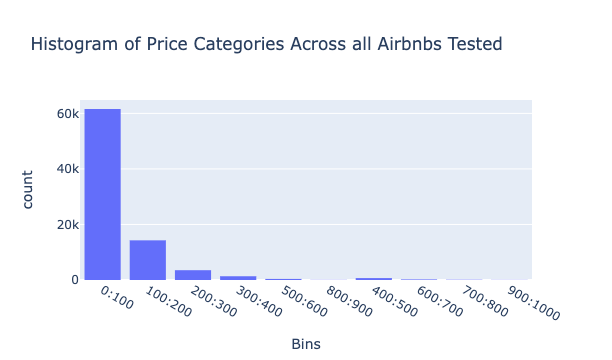

In [4]:
priceSuccessData = airbnb_raw_plus_review
priceSuccessData = priceSuccessData.dropna()
priceSuccessData['Bins'] = pd.cut(priceSuccessData.price_USD, bins=[0,100,200,300,
                                                                    400,500,600,700,
                                                                    800,900,1000], labels = ['0:100','100:200','200:300','300:400',
                                                                                             '400:500','500:600','600:700','700:800',
                                                                                             '800:900','900:1000'])
px.histogram(priceSuccessData, x='Bins', title = "Histogram of Price Categories Across all Airbnbs Tested")

## SuperHost/Review Status ScatterPlots

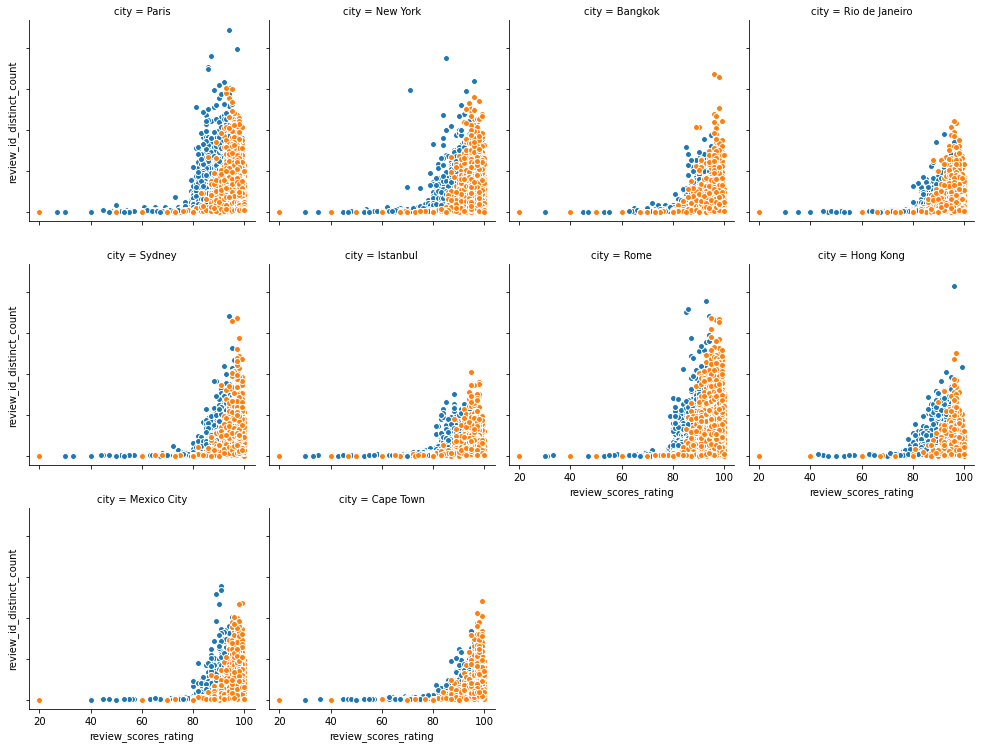

In [5]:
graph = sns.FacetGrid(airbnb_raw_plus_review, col ='city', hue='host_is_superhost', col_wrap = 4, height=3.5, aspect = 1, legend_out = False, ylim =None)
graph.map(plt.scatter, 'review_scores_rating', 'review_id_distinct_count', edgecolor ="w")
graph.set(yticklabels=[])
plt.show()

## Natural Language Processing

In [6]:
airbnb_text_paris = airbnb_raw_plus_review.loc[airbnb_raw_plus_review['city'] == 'Paris']
airbnb_text_newyork = airbnb_raw_plus_review.loc[airbnb_raw_plus_review['city'] == 'New York']
airbnb_text_mexicocity = airbnb_raw_plus_review.loc[airbnb_raw_plus_review['city'] == 'Mexico City']



#function to get the text column 'name' of Paris listings ready for NLP
def NLP_prep(airbnb_raw_plus_review):
    #pulling relevant columns for this analysis
    listing_name = airbnb_raw_plus_review.loc[:, ['name','city'] ]
    #removing non-alphabetical characters from text column, create new column 'name_str'
    listing_name['name_str'] = listing_name['name'].fillna('').astype(str).str.replace(r'[^A-Za-z ]', '', regex=True).replace('', np.nan, regex=False)
    # drop nan rows from name_str column
    listing_name = listing_name.dropna(subset=['name_str'])
    #keeping unique words in each row of the string column
    listing_name['name_str_nodup'] = (listing_name['name_str'].str.split()
                                  .apply(lambda x: OrderedDict.fromkeys(x).keys())
                                  .str.join(' '))
    return listing_name['name_str_nodup']
#listing_name.head(100)
listingtext = NLP_prep(airbnb_text_paris)
# NLP_prep()'s output is used as input for the NLP_airbnb() function which does word analysis.
def NLP_airbnb(listingtext):
    listingtext =" ".join(listingtext)
    # creates tokens, creates lower class, removes numbers and lemmatizes the words
    new_tokens = word_tokenize(listingtext)
    new_tokens = [t.lower() for t in new_tokens]
    new_tokens = [t for t in new_tokens if t not in stopwords.words('english', 'french')]
    new_tokens = [t for t in new_tokens if t.isalpha()]
    lemmatizer = WordNetLemmatizer()
    new_tokens = [lemmatizer.lemmatize(t) for t in new_tokens]
    #counts the frequencies
    counted = Counter(new_tokens)
    counted_2 = Counter(ngrams(new_tokens,2))
    counted_3 = Counter(ngrams(new_tokens,3))
    #generates separate dataframes for each type of combination
    word_freq = pd.DataFrame(counted.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
    word_pairs = pd.DataFrame(counted_2.items(),columns=['bigrams','frequency']).sort_values(by='frequency',ascending=False)
    trigrams = pd.DataFrame(counted_3.items(),columns=['trigrams','frequency']).sort_values(by='frequency',ascending=False)
    return word_freq,word_pairs,trigrams

word1, bigrams1, trigrams1 = NLP_airbnb(listingtext)

#These are for Paris only
word1, bigrams1, trigrams1 = NLP_airbnb(listingtext)

#function to get the text column 'name' of New York listings ready for NLP
def NLP_prep(airbnb_raw_plus_review):
    #pulling relevant columns for this analysis
    listing_name = airbnb_raw_plus_review.loc[:, ['name','city'] ]
    #removing non-alphabetical characters from text column, create new column 'name_str'
    listing_name['name_str'] = listing_name['name'].fillna('').astype(str).str.replace(r'[^A-Za-z ]', '', regex=True).replace('', np.nan, regex=False)
    # drop nan rows from name_str column
    listing_name = listing_name.dropna(subset=['name_str'])
    #keeping unique words in each row of the string column
    listing_name['name_str_nodup'] = (listing_name['name_str'].str.split()
                                  .apply(lambda x: OrderedDict.fromkeys(x).keys())
                                  .str.join(' '))
    return listing_name['name_str_nodup']
#listing_name.head(100)
listingtext = NLP_prep(airbnb_text_newyork)
# NLP_prep()'s output is used as input for the NLP_airbnb() function which does word analysis.
def NLP_airbnb(listingtext):
    listingtext =" ".join(listingtext)
    # creates tokens, creates lower class, removes numbers and lemmatizes the words
    new_tokens = word_tokenize(listingtext)
    new_tokens = [t.lower() for t in new_tokens]
    new_tokens = [t for t in new_tokens if t not in stopwords.words('english', 'french')]
    new_tokens = [t for t in new_tokens if t.isalpha()]
    lemmatizer = WordNetLemmatizer()
    new_tokens = [lemmatizer.lemmatize(t) for t in new_tokens]
    #counts the frequencies
    counted = Counter(new_tokens)
    counted_2 = Counter(ngrams(new_tokens,2))
    counted_3 = Counter(ngrams(new_tokens,3))
    #generates separate dataframes for each type of combination
    word_freq = pd.DataFrame(counted.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
    word_pairs = pd.DataFrame(counted_2.items(),columns=['bigrams','frequency']).sort_values(by='frequency',ascending=False)
    trigrams = pd.DataFrame(counted_3.items(),columns=['trigrams','frequency']).sort_values(by='frequency',ascending=False)
    return word_freq,word_pairs,trigrams

word2, bigrams2, trigrams2 = NLP_airbnb(listingtext)

#These are for New York only
word2, bigrams2, trigrams2 = NLP_airbnb(listingtext)

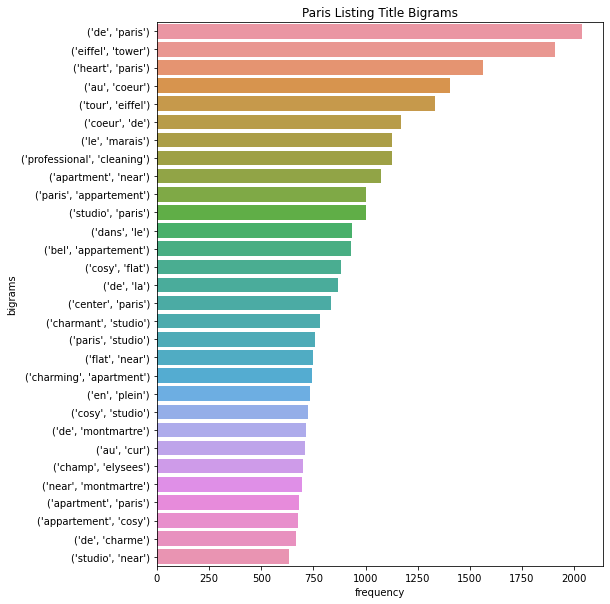

In [7]:
#For Paris Data

fig, axes=plt.subplots(1,1, figsize=(8,10))
sns.barplot(ax=axes,x='frequency',y='bigrams',data=bigrams1.head(30)).set_title("Paris Listing Title Bigrams")
plt.show()

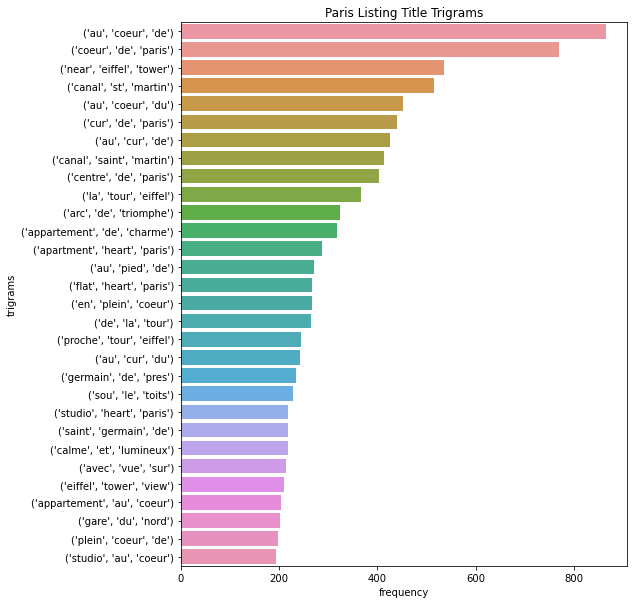

In [8]:
fig, axes=plt.subplots(1,1, figsize=(8,10))
sns.barplot(ax=axes,x='frequency',y='trigrams',data=trigrams1.head(30)).set_title("Paris Listing Title Trigrams")
plt.show()

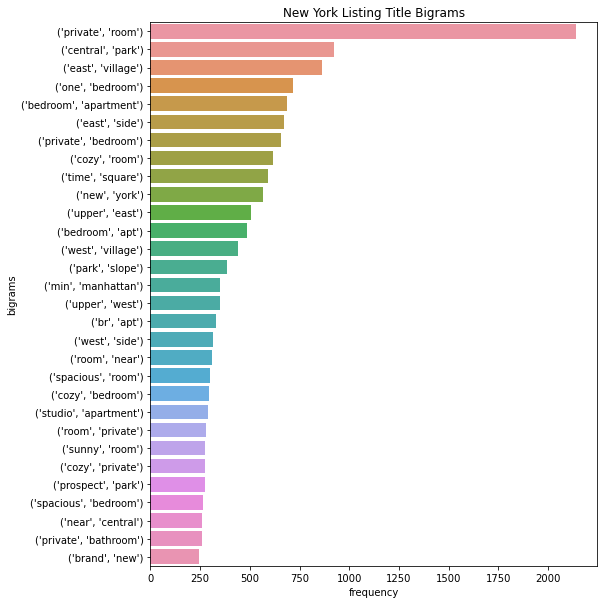

In [9]:
#For New York Data

fig, axes = plt.subplots(1,1,figsize=(8,10))
sns.barplot(ax=axes,x='frequency',y='bigrams',data=bigrams2.head(30)).set_title("New York Listing Title Bigrams")
plt.show()

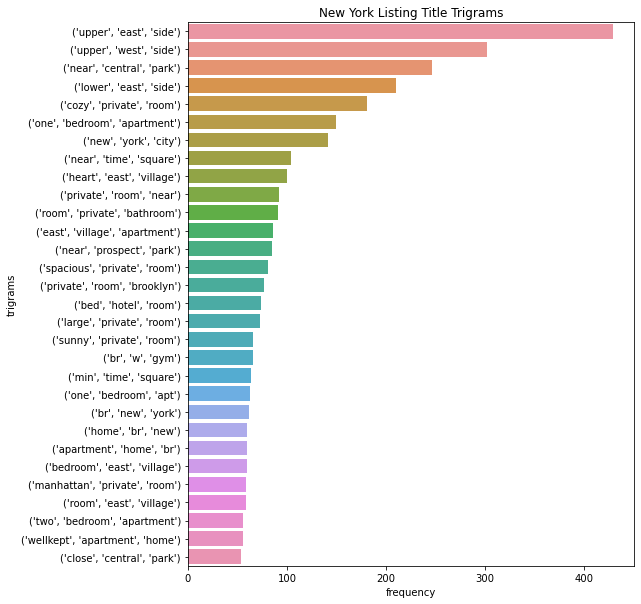

In [10]:
fig, axes = plt.subplots(1,1,figsize=(8,10))
sns.barplot(ax=axes,x='frequency',y='trigrams',data=trigrams2.head(30)).set_title("New York Listing Title Trigrams")
plt.show()